In [1]:
# Imports
import pathlib
import csv

import random
import numpy as np
#from tqdm.auto import tqdm
from PIL import Image

#from IPython.display import display
import matplotlib.pyplot as plt

import torch
#import torch.nn as nn
#import torch.optim as optim

#from torchvision.utils import make_grid
import torchvision.transforms as transforms
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# @markdown `shuffle-spli and dataset constructor`
def shuffle_and_split_data(X, y, seed, split_percent=0.2):
  """
  Helper function to shuffle and split data, yoinked from W1D3 tutorial

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(split_percent * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train


def get_datasets(images_pathfull, image_name_prefix, CSVlabels_pathfull, N_samples, percent_test, percent_valid, transform=None):
    """
    Helper function to get train, test, and validation datasets, do note that the images come out rescaled to [0,1]

    Args:
        images_pathfull: string
            path to the folder that includes all the images
        image_name_prefix: string
            the first part of the image name, with full filename being image_name_prefix+"INTEGER"+".png"
        CSVlabels_pathfull: string
            path to a .CSV file that includes all the labels
        N_samples: integer
            total number of samples to procure
        transform: torch.transform
            additional transformations to apply to images
        percent_test: float
            ratio of N_samples to be moved to test dataset, test dataset size is N_samples*percent_test
        percent_valid: float
            ratio of N_samples to be moved to valid dataset, valid dataset size is N_samples*percent_valid
      
    Returns:
        train_data: torch.TensorDataset
            train data, comes out shuffled, total number of samples = N_samples*(1-percent_test-percent_valid) 
        test_data: torch.TensorDataset
            test data, comes out shuffled, total number of samples = N_samples*percent_test
        valid_data: torch.TensorDataset
            validation data, comes out shuffled, total number of samples = N_samples*percent_valid
    """  
    #LABELS...
    #load the labels
    with open(images_pathfull, newline='') as csvfile:
        CSVlabels = list(csv.reader(csvfile))
    assert len(labels) >= N_samples
    #take N_samples from the total dataset
    shuffled_indices = torch.randperm(int(len(labels)))[:N_samples]
    labels = [CSVlabels[i] for i in shuffled_indices]
    #encode strings into numbers and store in a np array
    #what follows is a very dumb implementation of the aforementioned
    string_size=len(labels[0][0])
    np_labels = np.empty((1,string_size))
    for dat in labels:
        i=0
        temp = np.empty((1,string_size))
        for char in dat[0]:
            score = 4*(ord(char)-96) #get ascii code for char, rescale to 0-100
            if score == -256: score = 0 #set spaces to 0s (otherwise, they end up very negative)
            temp[0,i] = score
            i+=1
        np_labels = np.vstack((np_labels, temp))
    np_labels = np_labels[1:,:]
    #finally transform the labels to tensors
    trans_totensor = transforms.ToTensor()
    y_tensor = totensor_trans(np_labels)[0]

    #IMAGES...
    #prepare transforms, then load all the images  
    trans_to_img = transforms.PILToTensor()
    #load first image, then concat all the others
    im = Image.open( os.path.join(images_pathfull, image_name_prefix + f"{shuffled_indices[0]}.png") )
    im_tensor = 1.-trans_to_img(im).float()/255.
    for i in shuffled_indices[1:]:
        im = Image.open( os.path.join(images_pathfull, image_name_prefix + {i} + ".png") )
        im_tensor = torch.cat((im_tensor, 1.-trans_to_img(im).float()/255. ),0)
    #apply additional transform is speficied
    if transform != None: im_tensor=transform(im_tensor)
        
    #shuffle and split our data
    X_test, y_test, X_train, y_train = shuffle_and_split_data( X=im_tensor, y=y_tensor, seed=SEED,
                                                               split_percent=percent_test )
    X_test, y_test, X_valid, y_valid = shuffle_and_split_data( X=X_test,    y=y_test, seed=SEED,
                                                               split_percent= percent_valid/(1-percent_test) )
   
    
    test_data =  TensorDataset(X_test,  y_test)
    train_data = TensorDataset(X_train, y_train)
    valid_data = TensorDataset(X_valid, y_valid)
    return train_data, test_data, valid_data


In [ ]:
#usage code example...

train_data, test_data, valid_data = get_datasets(
    images_pathfull="/home/workstation319/Desktop/python/NMA codes and stuffs/project/temp", 
    image_name_prefix="base_img", 
    CSVlabels_pathfull="/home/workstation319/Desktop/python/NMA codes and stuffs/project/labels.csv", 
    N_samples=int(1e4), 
    percent_test=0.1, 
    percent_valid=0.2, 
    transform=None
)
# we should be able to use predefined torch dataloader:
batch_size = 256
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True, 
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )
test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )
valid_loader = DataLoader(valid_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

In [115]:
with open('test.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
    #reader = csv.DictReader(csvfile)
    for row in data:
        print(row)

shuffled_indices = torch.randperm(5)[:4]
extracted_data = [data[i] for i in shuffled_indices]

np_data = np.empty((1,len(extracted_data[0][0])))
string_size=len(extracted_data[0][0])
for dat in extracted_data:
    i=0
    temp = np.empty((1,string_size))
    for char in dat[0]:
        score = 4*(ord(char)-96) #get ascii code for char
        if score == -256: score = 0 #rescale to 0-100, set spaces to 0s
        temp[0,i] = score
        i+=1
        print(char,end =" ")
        print(score,end =" ")
    np_data = np.vstack((np_data, temp))
    print("\n")
    #print(dat[0])
np_data = np_data[1:,:]
totensor_trans = transforms.ToTensor()
print(np_data)
torch_data = totensor_trans(np_data)[0]
print(np_data)
print(torch_data[:2])

['qwertyuirg']
['ouahvoidev']
['noiancevtw']
['apijvcevae']
['aec gregeg']
['oahvie oej']
q 68 w 92 e 20 r 72 t 80 y 100 u 84 i 36 r 72 g 28 

a 4 e 20 c 12   0 g 28 r 72 e 20 g 28 e 20 g 28 

n 56 o 60 i 36 a 4 n 56 c 12 e 20 v 88 t 80 w 92 

a 4 p 64 i 36 j 40 v 88 c 12 e 20 v 88 a 4 e 20 

[[ 68.  92.  20.  72.  80. 100.  84.  36.  72.  28.]
 [  4.  20.  12.   0.  28.  72.  20.  28.  20.  28.]
 [ 56.  60.  36.   4.  56.  12.  20.  88.  80.  92.]
 [  4.  64.  36.  40.  88.  12.  20.  88.   4.  20.]]
[[ 68.  92.  20.  72.  80. 100.  84.  36.  72.  28.]
 [  4.  20.  12.   0.  28.  72.  20.  28.  20.  28.]
 [ 56.  60.  36.   4.  56.  12.  20.  88.  80.  92.]
 [  4.  64.  36.  40.  88.  12.  20.  88.   4.  20.]]
tensor([[ 68.,  92.,  20.,  72.,  80., 100.,  84.,  36.,  72.,  28.],
        [  4.,  20.,  12.,   0.,  28.,  72.,  20.,  28.,  20.,  28.]],
       dtype=torch.float64)


torch.Size([1, 43, 396])
(tensor([[0.0627, 0.0706, 0.1059,  ..., 0.0392, 0.0431, 0.0706],
        [0.0824, 0.0549, 0.0627,  ..., 0.0392, 0.0510, 0.0784],
        [0.1333, 0.0745, 0.0824,  ..., 0.0353, 0.0431, 0.0706],
        ...,
        [0.1490, 0.1176, 0.0941,  ..., 0.1216, 0.0275, 0.0667],
        [0.0627, 0.0549, 0.0706,  ..., 0.1216, 0.0275, 0.0667],
        [0.0510, 0.0549, 0.0941,  ..., 0.1216, 0.0275, 0.0667]]), tensor([ 68.,  92.,  20.,  72.,  80., 100.,  84.,  36.,  72.,  28.],
       dtype=torch.float64))


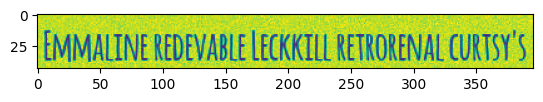

In [116]:
path="/home/workstation319/Desktop/python/NMA codes and stuffs/project/temp"
im = Image.open(path + "/example_002.jpg")
trans_to_img = transforms.PILToTensor()
im_tensor = 1.-trans_to_img(im).float()/255.
plt.imshow(im)
print(im_tensor.shape)
im_tensor = torch.cat((im_tensor, trans_to_img(im).float()/2 ),0)
im_tensor.shape
#plt.imshow(im)
#plt.imshow(im_tensor)

print(TensorDataset(im_tensor,  torch_data[:2])[0])